In [1]:
#imported libraries
import re
import pandas as pd
import emoji
from collections import Counter
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as mpl

In [2]:
#function to clean data
def clean_text(message):
    message = message.replace('<Media omitted>', ' ')   #takes out "<Media omitted>" from the data
    message = message.replace('null', '')   #takes out "null" from the data
    message = message.replace('This message was deleted', ' ')   #takes out "This message was deleted" from the data
    message = re.sub(r'http\S+', '', message)    #takes out links
    message = re.sub(r' [0-9]+', ' ', message)  #takes out numbers
    message = re.sub(r'\s+', ' ', message)   #takes out multiple word
    message = re.sub(r'[^\w\s\U0001F300-\U0001F6FF]', '', message)   #takes out any foreing character except emojis
    message = re.sub(r' ([a-zA-Z])\1\1', r'\1', message)    #takes out repeated characters
    
    emojis = ''.join(c for c in message if c in emoji.EMOJI_DATA)
    for c in message:        #Function to check for the presence of emojis
        if emoji.is_emoji(c):
            emojis += c
    message = re.sub(r'[^\w\s]', '', message)  # Remove non-alphanumeric characters
    message += emojis  # Append emojis to emoji_data list
    
    message = re.sub(r'(\w)\1{2,}', r'\1\1', message)     #Remove repeated characters (e.g., "looool" -> "lool")
    
    
    
    if message.strip() == '':     #takes put multiple spaces
        message = message.replace(' ', '')
    
    return message.strip()

In [3]:
#function to split data into 
def split_data(line):
    pattern = r'^(\d{2}/\d{2}/\d{2}), (\d{1,2}:\d{2})\s?(am|pm) - (\+?\d{3} \d{2} \d{3} \d{4}): (.+)$'
    match = re.match(pattern, line)

    if match:
        date = match.group(1)
        time = match.group(2) + " " + match.group(3)
        user = match.group(4)
        message = clean_text(match.group(5))  # Clean the message
        
        emojis = ''
        # Check if each character in the message is an emoji
        for c in message:
            if emoji.is_emoji(c):
                emojis += c
        
        return date, time, user, message, emojis
    else:
        return None

In [4]:
#main code
data_path = 'C:/Users/kingr/Desktop/sentimental analysis 2/chats.txt'
with open(data_path, 'r', encoding='utf-8') as data_file:
    lines = data_file.readlines()

date_data = []
time_data = []
users_data = []
message_data = []
clean_message_data = []
emoji_data = []
emoji_counts = {}
word_counts = Counter()

for line in lines:
    detail = split_data(line)
    
    if detail:
        date, time, user, message, emojis = detail
        if message:
            date_data.append(date)
            time_data.append(time)
            users_data.append(user)
            message_data.append(message)
            for c in message:
                if c in emoji.EMOJI_DATA:
                    if c not in emoji_counts:
                        emoji_counts[c] = 1
                    else:
                        emoji_counts[c] += 1
            clean_message_data.append(message)
            message = re.sub(r'[^\w\s]', '', message)
            words = message.split()
            word_counts.update(words)
            emoji_data.append(emojis)

In [5]:
#create dataframe for DATE, TIME, USER, MESSAGE, MESSAGE WITHOUT EMOJIS, EMOJI
df = pd.DataFrame({'DATE': date_data,
                   'TIME': time_data,
                   'USER': users_data,
                   'MESSAGE': message_data,
                   'NEAT MESSAGE': clean_message_data,
                   'EMOJIS': emoji_data})  

df.drop_duplicates(subset=['MESSAGE'], inplace=True)

In [6]:
#Check Sentiments and create dataframe for "user, message, sentiment score and sentiment"

nltk.download('vader_lexicon')   #Download VADER lexicon

analyzer = SentimentIntensityAnalyzer()    #Initialize the VADER sentiment analyzer

def get_sentiment_score(text):      #Function to get sentiment score for each message
    return analyzer.polarity_scores(text)['compound']

df['SENTIMENT_SCORE'] = df['MESSAGE'].apply(get_sentiment_score)     #Apply sentiment analysis to each message

def classify_sentiment(score):       #Function to classify sentiment based on score
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'


df['SENTIMENT'] = df['SENTIMENT_SCORE'].apply(classify_sentiment)  #Apply sentiment classification


sentiment_data=df[['USER', 'MESSAGE', 'SENTIMENT_SCORE', 'SENTIMENT']]    #Display the DataFrame with sentiment analysis results

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kingr\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
# Create DataFrame from the emoji counts & Convert word counts to DataFrame
emoji_df = pd.DataFrame({'EMOJI': list(emoji_counts.keys()), 'COUNT': list(emoji_counts.values())})

word_counts_df = pd.DataFrame(word_counts.items(), columns=['WORD', 'COUNT'])

word_counts_df = word_counts_df.sort_values(by='COUNT', ascending=False)   #Sort DataFrame by count in descending order


In [8]:
#creates DataFrame for user emoji counts


# Group DataFrame by "USER" column and count number of messages per user
user_message_counts = df.groupby('USER').size().reset_index(name='NUMBER OF MESSAGES')

user_emoji_counts = []            #Initialize lists to store number of emojis
user_emojis = []                  #lists to store emojis for each user

for user in df['USER'].unique():    #function to Iterate over unique users to count emojis and collect emojis for each user
    user_messages = df[df['USER'] == user]['NEAT MESSAGE']
    emojis = ''.join(c for message in user_messages for c in message if c in emoji.EMOJI_DATA)
    emoji_count = len(emojis)
    user_emoji_counts.append(emoji_count)
    user_emojis.append(emojis)

# Create a DataFrame with user, number of messages, number of emojis, and emojis
user_emoji_df = pd.DataFrame({
    'USER': df['USER'].unique(),
    'NUMBER OF MESSAGES': user_message_counts['NUMBER OF MESSAGES'],
    'NUMBER OF EMOJIS': user_emoji_counts,
    'EMOJIS': user_emojis
})

In [9]:
#save dataframes to csv file


df.to_csv('Final data.csv', index=False) #DATE, TIME, USER, MESSAGE, MESSAGE WITHOUT EMOJIS and EMOJI 

sentiment_data.to_csv('Sentiment Data.csv', index=False)    #User, Message, Sentiment_Score, Sentiment

emoji_df.to_csv('emoji_counts.csv', index=False)     #emoji count
 
word_counts_df.to_csv('word_counts.csv', index=False)     #word count

user_emoji_df.to_csv('user_emoji_counts.csv', index=False)  #user to emoji count

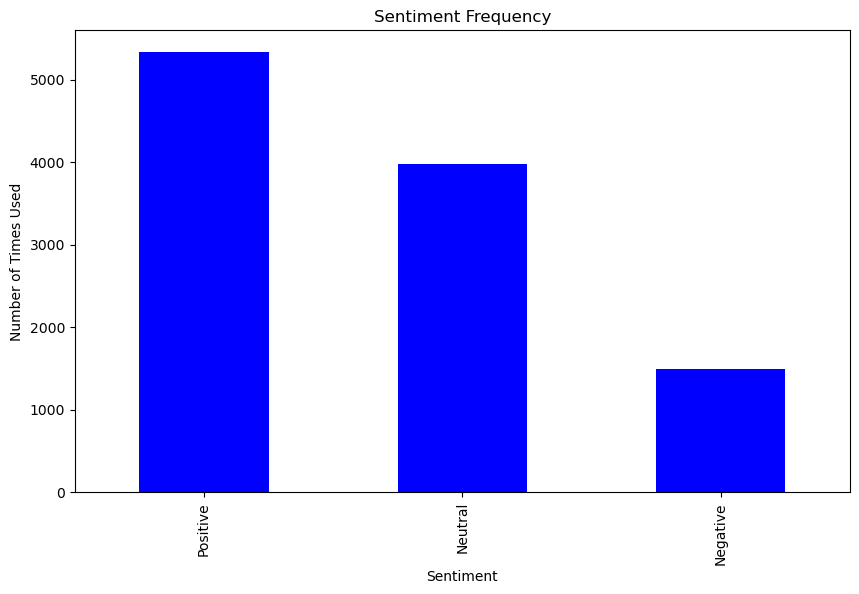

In [10]:
#plot
sentiment_counts = df['SENTIMENT'].value_counts()

mpl.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color='b')
mpl.xlabel('Sentiment')
mpl.ylabel('Number of Times Used')
mpl.title('Sentiment Frequency')
mpl.show()

In [11]:
#print DataFrames
print(df)
print(sentiment_data)
print(emoji_df)
print(word_counts_df)
print(user_emoji_df)

           DATE     TIME              USER  \
0      23/09/23  2:06 pm  +233 55 624 6989   
1      24/09/23  8:39 pm  +233 55 427 0384   
2      24/09/23  8:40 pm  +233 55 631 5930   
3      24/09/23  8:44 pm  +233 55 052 9435   
4      24/09/23  8:46 pm  +233 59 273 8323   
...         ...      ...               ...   
13338  28/04/24  9:31 pm  +233 50 561 5705   
13339  28/04/24  9:31 pm  +233 59 472 1501   
13340  28/04/24  9:33 pm  +233 59 664 4784   
13341  28/04/24  9:56 pm  +233 25 673 3014   
13343  28/04/24  9:58 pm  +233 50 561 5705   

                                                 MESSAGE  \
0      CANADA  FULLY FUNDED SCHOLARSHIPS 2024 ONGOING...   
1                                              Chai 😂😂😂😂   
2                                               Skkrr 😂😂   
3                      So people really check this err😂😂   
4                                    Check and see😂😂😂😂😂😂   
...                                                  ...   
13338  This is for both gen